**SECTION 1 — Notebook Setup**

Environment Setup

In [71]:
# Install required packages
!pip install mediapipe opencv-python librosa torch torchvision torchaudio \
            fastapi uvicorn scikit-learn matplotlib seaborn pandas tqdm


Imports & Seed

In [72]:
import numpy as np
import pandas as pd
import torch
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


**SECTION 2 — Dataset Loading & Exploration**

Load Processed Dataset

In [73]:
df = pd.read_csv("/Users/venturit/Documents/GitHub/FYP/CausalX-Project/backend/data/processed/causal_multimodal_dataset.csv")
df.head()

,jitter_mean,jitter_std,av_correlation,av_lag_frames,lip_variance,det_count,video_id,label,dataset,video_fake,audio_fake
0,0.025954,0.019321,-0.033838,-45,0.180140,300,aagfhgtpmv.mp4,1,DFDC,-1,-1
1,0.080513,0.141131,0.140694,-4,0.252437,169,aapnvogymq.mp4,1,DFDC,-1,-1
2,0.023488,0.030142,0.346990,185,0.330738,300,abarnvbtwb.mp4,0,DFDC,-1,-1
3,0.020004,0.024657,0.034105,-5,0.187281,300,abqwwspghj.mp4,1,DFDC,-1,-1
4,0.128620,0.088331,-0.443419,-4,0.322993,19,acqfdwsrhi.mp4,1,DFDC,-1,-1


Class Distribution

In [74]:
df["label"].value_counts(normalize=True)

label
1    0.974549
0    0.025451
Name: proportion, dtype: float64

**SECTION 3 — Preprocessing Techniques (EXPERIMENTAL)**

Feature Normalization Variants

In [75]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = df[[
    "lip_variance", "av_correlation", "av_lag_frames",
    "jitter_mean", "jitter_std"
]]

scaler_std = StandardScaler()
scaler_minmax = MinMaxScaler()

X_std = scaler_std.fit_transform(X)
X_mm = scaler_minmax.fit_transform(X)

**SECTION 4 — Baseline Models (Non-Causal)**

Logistic Regression

In [76]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight="balanced")
clf.fit(X_std, df["label"])

preds = clf.predict(X_std)
probs = clf.predict_proba(X_std)[:, 1]

report = classification_report(df["label"], preds, output_dict=True)
roc = roc_auc_score(df["label"], probs)



Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, class_weight="balanced")
rf.fit(X_std, df["label"])

probs = rf.predict_proba(X_std)[:, 1]
preds = rf.predict(X_std)

print(classification_report(df["label"], preds))
print("ROC-AUC:", roc_auc_score(df["label"], probs))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       542
           1       1.00      1.00      1.00     20754

    accuracy                           1.00     21296
   macro avg       1.00      1.00      1.00     21296
weighted avg       1.00      1.00      1.00     21296

ROC-AUC: 1.0


**SECTION 5 — Causal Feature Validation**

Causal Intervention Test

In [78]:
def intervention_flip_rate(feature):
    perturbed = X_std.copy()
    perturbed[:, feature] = np.random.permutation(perturbed[:, feature])
    probs = clf.predict_proba(perturbed)[:, 1]
    return np.mean(np.abs(probs - clf.predict_proba(X_std)[:, 1]) > 0.5)

features = X.columns
for i, f in enumerate(features):
    print(f, intervention_flip_rate(i))

lip_variance 0.0
av_correlation 0.0
av_lag_frames 0.0
jitter_mean 9.391435011269723e-05
jitter_std 0.0023009015777610818


**SECTION 6 — CFN (Causal Fusion Network)**

CFN Architecture

In [79]:
class CausalFusionNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = torch.nn.Parameter(torch.tensor(0.5))
        self.beta = torch.nn.Parameter(torch.tensor(0.5))

        self.av_net = torch.nn.Sequential(
            torch.nn.Linear(3, 8),
            torch.nn.ReLU()
        )

        self.phys_net = torch.nn.Sequential(
            torch.nn.Linear(2, 8),
            torch.nn.ReLU()
        )

        self.out = torch.nn.Sequential(
            torch.nn.Linear(8, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, av, phys):
        fused = self.alpha * self.av_net(av) + self.beta * self.phys_net(phys)
        return self.out(fused)

CFN Training

In [80]:
from torch.utils.data import TensorDataset, DataLoader

X_av = torch.tensor(X_std[:, :3], dtype=torch.float32)
X_phys = torch.tensor(X_std[:, 3:], dtype=torch.float32)
y = torch.tensor(df["label"].values, dtype=torch.float32).unsqueeze(1)

loader = DataLoader(TensorDataset(X_av, X_phys, y), batch_size=64, shuffle=True)

model = CausalFusionNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.BCELoss()

for epoch in range(20):
    for av, phys, label in loader:
        opt.zero_grad()
        loss = loss_fn(model(av, phys), label)
        loss.backward()
        opt.step()

print("Alpha:", model.alpha.item(), "Beta:", model.beta.item())


Alpha: 1.0311429500579834 Beta: 0.9890584945678711


**SECTION 7 — Frame-Level Inference**

Frame-Level CFN Output

In [81]:
import os, sys
PROJECT_ROOT = "/Users/venturit/Documents/GitHub/FYP/CausalX-Project/backend"
sys.path.append(PROJECT_ROOT)
os.chdir(PROJECT_ROOT)

from src.cvi.cfn_frame_inference import run_cfn_on_video
from src.cvi.api.inference_service import summarize_video

VIDEO_PATH = "/Users/venturit/Documents/GitHub/FYP/CausalX-Project/backend/data/raw/fakeavceleb/FakeVideo-RealAudio/Caucasian (European)/women/id00071/00014_id00330_wavtolip.mp4"  # change accordingly

frames = run_cfn_on_video(
    video_path=VIDEO_PATH,
    threshold=0.6,
    chunk_seconds=10,
    max_seconds=None,
)

len(frames), frames[0].keys()

video_fake, fake_conf, highlight = summarize_video(
    frames,
    prob_thresh=0.6,
    ratio_thresh=0.3
)

video_fake, fake_conf, highlight[:5]


/Users/venturit/Documents/GitHub/FYP/CausalX-Project/backend/src/cvi/frame_causal_extractor.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(
/Users/venturit/Documents/GitHub/FYP/CausalX-Project/.venv/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


(1, 1.0, [0.0, 0.04, 0.08, 0.12, 0.16])

### 7.1 Visualization: timeline and bounding boxes
Highlight red regions where fake probability crosses threshold and draw bboxes on those frames.

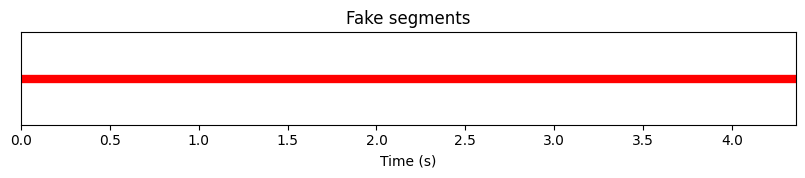

[(0.0, 4.36)]

In [82]:
import matplotlib.pyplot as plt

# Build contiguous fake segments from frame-level scores

def get_fake_segments(frames, prob_thresh=0.6, min_run=2):
    mask = [f.get("fake_prob", 0) >= prob_thresh for f in frames]
    segments = []
    start = None
    for i, flag in enumerate(mask):
        if flag and start is None:
            start = i
        if not flag and start is not None:
            if i - start >= min_run:
                segments.append((frames[start]["timestamp"], frames[i-1]["timestamp"]))
            start = None
    if start is not None and len(mask) - start >= min_run:
        segments.append((frames[start]["timestamp"], frames[len(mask)-1]["timestamp"]))
    return segments


def plot_fake_timeline(frames, segments, title="Fake segments"):
    if not frames:
        print("No frames available")
        return
    total_time = frames[-1]["timestamp"] if frames else 0
    plt.figure(figsize=(10, 1.2))
    for s, e in segments:
        plt.hlines(1, s, e, colors="red", linewidth=6)
    plt.xlim(0, total_time)
    plt.yticks([])
    plt.xlabel("Time (s)")
    plt.title(title)
    plt.show()

segments = get_fake_segments(frames, prob_thresh=0.6, min_run=2)
plot_fake_timeline(frames, segments)
segments

In [83]:
import cv2
from pathlib import Path

def render_fake_bboxes(video_path, frames, prob_thresh=0.6, out_path="annotated_fakes.mp4"):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    fps = cap.get(cv2.CAP_PROP_FPS) or 25
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writer = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

    frame_map = {int(f["timestamp"] * fps): f for f in frames if f.get("fake_prob", 0) >= prob_thresh and f.get("bbox")}

    idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        info = frame_map.get(idx)
        if info and info.get("bbox"):
            x1, y1, x2, y2 = info["bbox"]
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
        writer.write(frame)
        idx += 1

    cap.release()
    writer.release()
    return Path(out_path)

render_fake_bboxes(VIDEO_PATH, frames, prob_thresh=0.6)

PosixPath('annotated_fakes.mp4')

### 7.2 Technique sweeps and logging
Compare detection techniques (thresholds, smoothing) and log results.

In [84]:
import time, json
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.ndimage import uniform_filter1d
from src.cvi.api.inference_service import summarize_video

LOG_PATH = Path("notebooks/technique_runs.csv")


def apply_technique(video_path, prob_thresh=0.6, ratio_thresh=0.3, smoothing=None, label="base"):
    frames_local = run_cfn_on_video(video_path, threshold=prob_thresh)
    if smoothing:
        probs = np.array([f["fake_prob"] for f in frames_local])
        smooth = uniform_filter1d(probs, size=smoothing, mode="nearest")
        for f, s in zip(frames_local, smooth):
            f["fake_prob"] = float(s)
    video_fake, fake_conf, highlight = summarize_video(frames_local, prob_thresh=prob_thresh, ratio_thresh=ratio_thresh)
    segments = get_fake_segments(frames_local, prob_thresh=prob_thresh, min_run=2)
    record = {
        "timestamp": time.time(),
        "video": video_path,
        "label": label,
        "prob_thresh": prob_thresh,
        "ratio_thresh": ratio_thresh,
        "smoothing": smoothing or 0,
        "video_fake": video_fake,
        "fake_conf": fake_conf,
        "segments": len(segments),
        "segment_spans": json.dumps(segments),
    }
    return record, frames_local, segments


def log_record(record):
    LOG_PATH.parent.mkdir(exist_ok=True)
    if LOG_PATH.exists():
        df = pd.read_csv(LOG_PATH)
    else:
        df = pd.DataFrame()
    df = pd.concat([df, pd.DataFrame([record])], ignore_index=True)
    df.to_csv(LOG_PATH, index=False)
    return df.tail()


In [85]:
# Run a few candidate techniques and log
candidates = [
    {"label": "base", "prob_thresh": 0.6, "ratio_thresh": 0.3, "smoothing": None},
    {"label": "smooth5", "prob_thresh": 0.6, "ratio_thresh": 0.3, "smoothing": 5},
    {"label": "strict", "prob_thresh": 0.7, "ratio_thresh": 0.4, "smoothing": None},
]

records = []
for cfg in candidates:
    rec, frames_local, segments_local = apply_technique(VIDEO_PATH, **cfg)
    records.append(rec)
    log_record(rec)

pd.DataFrame(records)


/Users/venturit/Documents/GitHub/FYP/CausalX-Project/backend/src/cvi/frame_causal_extractor.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(
/Users/venturit/Documents/GitHub/FYP/CausalX-Project/.venv/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/Users/venturit/Documents/GitHub/FYP/CausalX-Project/backend/src/cvi/frame_causal_extractor.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(
/Users/venturit/Documents/GitHub/FYP/CausalX-Project/.venv/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


,timestamp,video,label,prob_thresh,ratio_thresh,smoothing,video_fake,fake_conf,segments,segment_spans
0,1.769357e+09,/Users/venturit/Documents/GitHub/FYP/CausalX-P...,base,0.6,0.3,0,1,1.000000,1,"[[0.0, 4.36]]"
1,1.769357e+09,/Users/venturit/Documents/GitHub/FYP/CausalX-P...,smooth5,0.6,0.3,5,1,1.000000,1,"[[0.0, 4.36]]"
2,1.769357e+09,/Users/venturit/Documents/GitHub/FYP/CausalX-P...,strict,0.7,0.4,0,1,0.981818,2,"[[0.04, 1.8], [1.88, 4.36]]"


In [86]:
# Pick the most confident technique (max fake_conf) for downstream use
results_df = pd.DataFrame(records)
best = results_df.sort_values("fake_conf", ascending=False).head(1)
best

,timestamp,video,label,prob_thresh,ratio_thresh,smoothing,video_fake,fake_conf,segments,segment_spans
0,1.769357e+09,/Users/venturit/Documents/GitHub/FYP/CausalX-P...,base,0.6,0.3,0,1,1.0,1,"[[0.0, 4.36]]"


/Users/venturit/Documents/GitHub/FYP/CausalX-Project/backend/src/cvi/frame_causal_extractor.py:45: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(
/Users/venturit/Documents/GitHub/FYP/CausalX-Project/.venv/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


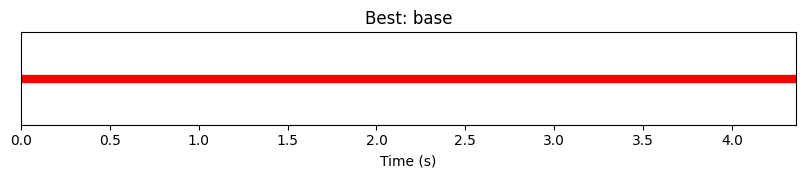

PosixPath('annotated_fakes.mp4')

In [87]:
# Example: use the best technique's frames to draw bboxes and timeline
best_cfg = candidates[int(best.index[0])]
rec_best, frames_best, segments_best = apply_technique(VIDEO_PATH, **best_cfg)
plot_fake_timeline(frames_best, segments_best, title=f"Best: {best_cfg['label']}")
render_fake_bboxes(VIDEO_PATH, frames_best, prob_thresh=best_cfg['prob_thresh'])

**SECTION 8 — Video-Level Aggregation (EXPERIMENTAL)**

Aggregation Methods

In [88]:
def aggregate(probs, method="topk"):
    if method == "mean":
        return probs.mean()
    if method == "max":
        return probs.max()
    if method == "topk":
        k = int(0.2 * len(probs))
        return np.sort(probs)[-k:].mean()

**SECTION 9 — CVI (Visualization Logic)**

Timestamp Highlighting Logic

In [89]:
fake_frames = [t for t, p in zip(times, probs) if p > 0.6]

NameError: name 'times' is not defined

**SECTION 10 — Final System Comparison**